<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training the Conditional Auto-Encoder with the settings obtained from Optimization


In [1]:
import tensorflow as tf
tf.__version__
tf.config.list_physical_devices('GPU')

import numpy as np
import scipy
import matplotlib.pyplot as plt
import os
import logging
import sys
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Reshape, LeakyReLU, BatchNormalization, Dense, Flatten, Input,Dropout
import random
import numpy as np
import pickle
import tensorflow_addons as tfa
import seaborn as sns
import pandas as pd
from sklearn import preprocessing


In [2]:
SMALL_SIZE =  14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [3]:
RUN             = '1'
EPOCHS          = 40

seeds           = {'1':512, '2':879, '3':9981, '4': 20075, '5': 66, '6': 276, '7': 936664}

conditional     = False
cond_on         = 'type'

root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'
root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'


wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
min_SN          = 50
min_z           = 0.05
max_z           = 0.36
label           = 'galaxies_quasars_bins%d_wl%d-%d'%(fixed_num_bins,wlmin,wlmax)
label_          = label+'_minz%s_maxz%s_minSN%d'%(str(int(min_z*100)).zfill(3),str(int(max_z*100)).zfill(3),min_SN)
label_2         = label_+'_10_fully_connected_mean_div_spec_norm'

plotpath        = '/global/homes/v/vboehm/codes/SDSS_PAE/figures'

if conditional:
    label_2='conditional_%s'%cond_on+label_2

In [14]:
random.seed(seeds[RUN])
np.random.seed(seeds[RUN])
tf.random.set_seed(seeds[RUN])

dim             = fixed_num_bins

optimizer       = tf.keras.optimizers.Adam
batchsize       = 38
decay_steps     = 2116
dropouts_dec    = [0.]
dropouts_enc    = [0.]
latent_dim      = 10
lr_final        = 8.356860244997504e-06
lr_init         = 0.0006475036164700997
out_features    = [215]

def dense_cond_block(x,z,num, non_lin=True):
    x = tf.concat([x,z], axis=1)
    x = Flatten()(x)
    x = Dense(num)(x)
    if non_lin:
        x = LeakyReLU()(x)
    return Reshape((num,1))(x)

def dense_block(x,num, non_lin=True,spec_norm=False):
    x = Flatten()(x)
    if spec_norm:
        x = tfa.layers.SpectralNormalization(Dense(num))(x)
    else:
        x = Dense(num)(x)
    if non_lin:
        x = LeakyReLU()(x)
    return Reshape((num,1))(x)


def lossFunction(y_true,y_pred,mask,inverse):
        loss = tf.math.square(y_true-y_pred)*inverse
        loss = tf.reduce_mean(tf.boolean_mask(loss,mask))
        return loss
    
from tensorflow.python.keras.engine import data_adapter


class CustomModel(tf.keras.Model):
    def compile(self, optimizer, my_loss,metrics, run_eagerly):
        super().compile(optimizer,metrics, run_eagerly)
        self.my_loss = my_loss

    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        input_data = data_adapter.unpack_x_y_sample_weight(data)
        with tf.GradientTape() as tape:
            y_pred = self(data, training=True)
            loss_value = self.my_loss(input_data[0][0],y_pred,input_data[0][1],input_data[0][2])

        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {"training_loss": loss_value}


def make_scheduler(length, initial_lr,factor=1.2):
    def scheduler(epoch, lr):
        if epoch < length:
            lr = initial_lr
            return lr
        else:
            return lr * tf.math.exp(-factor)
    return scheduler
                             
def training_cycle(BATCH_SIZE, n_epochs, lr_anneal, lr_initial, reduce_fac): 
    scheduler = make_scheduler(lr_anneal, lr_initial, reduce_fac)
    callback  = tf.keras.callbacks.LearningRateScheduler(scheduler)
    history   = lstm_ae.fit(x=(train_data,train_mask,train_noise, train_types, train_params), batch_size=BATCH_SIZE, epochs=n_epochs, callbacks=[callback],verbose=0)
    return history

def custom_metric(y_true, y_pred):
    loss = (y_true[0]-y_pred)**2*y_true[2]
    valid_loss = np.mean(loss[np.where(y_true[1])])
    return valid_loss

In [15]:
try:
    train,valid,test,le = pickle.load(open(os.path.join(root_model_data,'combined_%s_new.pkl'%label_),'rb'))
except:
    train_data = np.load(os.path.join(root_model_data,'train_%s_new.npy.npz'%label_))
    valid_data = np.load(os.path.join(root_model_data,'valid_%s_new.npy.npz'%label_))
    test_data = np.load(os.path.join(root_model_data,'test_%s_new.npy.npz'%label_))


    keys = ('spec', 'mask', 'noise', 'z', 'RA', 'DEC', 'class', 'subclass','SN','MJD','plate','fiber', 'mean', 'std')

    train = {}
    for item, key in zip(train_data.files, keys):
        train[key] = train_data[item]


    valid = {}
    for item, key in zip(valid_data.files, keys):
        valid[key] =  valid_data[item]

    test = {}
    for item, key in zip(test_data.files, keys):
        test[key] = test_data[item]


    le = preprocessing.LabelEncoder()
    le.fit(train['subclass'])
    train['subclass'] = le.transform(train['subclass'])
    valid['subclass'] = le.transform(valid['subclass'])
    test['subclass']  = le.transform(test['subclass'])
    print(le.classes_, le.transform(le.classes_))        

    pickle.dump([train,valid,test,le],open(os.path.join(root_model_data,'combined_%s_new.pkl'%label_),'wb'))


In [16]:
Supernovas = pd.read_pickle('../forPub/Supernova_Sample.pkl')
df1 = pd.DataFrame()
df1['MJD']   = train['MJD']
df1['plate'] = train['plate']
df1['fiber'] = train['fiber']
sns= df1.merge(Supernovas,how='inner',on=['plate','MJD','fiber'])
print(len(sns))
df1 = pd.DataFrame()
df1['MJD']   = valid['MJD']
df1['plate'] = valid['plate']
df1['fiber'] = valid['fiber']
sns= df1.merge(Supernovas,how='inner',on=['plate','MJD','fiber'])
print(len(sns))
df1 = pd.DataFrame()
df1['MJD']   = test['MJD']
df1['plate'] = test['plate']
df1['fiber'] = test['fiber']
sns= df1.merge(Supernovas,how='inner',on=['plate','MJD','fiber'])
print(len(sns))

7
3
3


In [18]:
input        = Input(shape=(dim,1))
input_mask   = Input(shape=(dim,1))
input_noise  = Input(shape=(dim,1))
input_type   = Input(shape=(1,1))
input_params = Input(shape=(1,1))

if cond_on=='type':
    z = input_type
if cond_on=='redshift':
    z = input_params

n_layers   = 2
latent_dim = latent_dim

x = input
for ii in range(n_layers-1):
    if ii>0:
        x = Dropout(dropouts_enc[ii-1])(x)
    x = dense_block(x,out_features[ii],spec_norm=True)
    
x = dense_block(x,latent_dim,non_lin=False,spec_norm=True)


for ii in range(n_layers-1):
    if conditional:
        x = dense_cond_block(x,z,out_features[-1-ii])
    else:
        x = dense_block(x,out_features[-1-ii])
    if ii ==0:
        pass
    else:
        x = Dropout(dropouts_dec[ii-1])(x)
if conditional:
    x = dense_cond_block(x,z,dim, non_lin=False)
else:
    x = dense_block(x,dim, non_lin=False)


learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
lr_init,
decay_steps,
lr_final,
power=0.5, cycle=True)

optim = optimizer

lstm_ae = CustomModel(inputs=[input,input_mask,input_noise, input_type, input_params], outputs=x)
lstm_ae.compile(optimizer=optim(learning_rate=learning_rate_fn), my_loss=lossFunction, metrics=[],run_eagerly=False)
lstm_ae.summary()

Model: "custom_model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 1000, 1)]    0                                            
__________________________________________________________________________________________________
flatten_27 (Flatten)            (None, 1000)         0           input_31[0][0]                   
__________________________________________________________________________________________________
spectral_normalization_16 (Spec (None, 215)          215430      flatten_27[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_19 (LeakyReLU)      (None, 215)          0           spectral_normalization_16[0][0]  
_____________________________________________________________________________________

In [19]:
path = os.path.join(root_models,'full_ae_model_%s_run%s_new'%(label_2,RUN))

lstm_ae.fit(x=(train['spec'],train['mask'],train['noise'], np.expand_dims(train['subclass'],-1), np.expand_dims(train['z'],-1)), batch_size=batchsize, epochs=EPOCHS)

res_valid   = lstm_ae.predict((valid['spec'],valid['mask'],valid['noise'], valid['subclass'], valid['z']))
recon_error = custom_metric((valid['spec'],valid['mask'],valid['noise'], valid['subclass'], valid['z']),res_valid)

print('final validation loss:', recon_error)
print('final validation reconstruction error:', np.sqrt(recon_error))


lstm_ae.save(path)

Epoch 1/40
5513/5513 [==============================] - 8s 1ms/step - training_loss: 3.6891
Epoch 2/40
5513/5513 [==============================] - 8s 1ms/step - training_loss: 1.6041
Epoch 3/40
5513/5513 [==============================] - 8s 1ms/step - training_loss: 1.4985
Epoch 4/40
5513/5513 [==============================] - 8s 1ms/step - training_loss: 1.4581
Epoch 5/40
5513/5513 [==============================] - 8s 1ms/step - training_loss: 1.4241
Epoch 6/40
5513/5513 [==============================] - 8s 1ms/step - training_loss: 1.4066
Epoch 7/40
5513/5513 [==============================] - 8s 1ms/step - training_loss: 1.3834
Epoch 8/40
5513/5513 [==============================] - 8s 1ms/step - training_loss: 1.3666
Epoch 9/40
5513/5513 [==============================] - 8s 1ms/step - training_loss: 1.3564
Epoch 10/40
5513/5513 [==============================] - 8s 1ms/step - training_loss: 1.3440
Epoch 11/40
5513/5513 [==============================] - 8s 1ms/step - training

In [20]:
for label in np.arange(8):
    print(le.inverse_transform([label]))
    index = np.where(valid['subclass']==label)[0]
    res_valid = lstm_ae.predict((valid['spec'][index],valid['mask'][index],valid['noise'][index], valid['subclass'][index], valid['z'][index]))
    print('validation: ', custom_metric((valid['spec'][index],valid['mask'][index],valid['noise'][index], valid['subclass'][index], valid['z'][index]),res_valid))
    index = np.where(train['subclass']==label)[0]
    lng   = min(len(res_valid),len(index))
    res_train = lstm_ae.predict((train['spec'][index][:lng],train['mask'][index][:lng],train['noise'][index][:lng], train['subclass'][index][:lng], train['z'][index][:lng]))
    print('training: ', custom_metric((train['spec'][index][:lng],train['mask'][index][:lng],train['noise'][index][:lng], train['subclass'][index][:lng], train['z'][index][:lng]),res_train))

[b'']
validation:  1.286444467988758
training:  1.2855836337558306
[b'AGN']
validation:  1.4513309557417657
training:  1.4675043184652667
[b'AGN BROADLINE']
validation:  2.1436847667964605
training:  2.231167889726918
[b'BROADLINE']
validation:  1.7441222143415185
training:  1.7917821197474304
[b'STARBURST']
validation:  1.6771123552992797
training:  1.6730970812540766
[b'STARBURST BROADLINE']
validation:  2.456731110352635
training:  2.3230285312310794
[b'STARFORMING']
validation:  1.366190048927587
training:  1.367222093994497
[b'STARFORMING BROADLINE']
validation:  1.629924748358625
training:  1.666587054955587


In [11]:
# def bootstrap(train_data, batch_size):
#     index   = np.arange(len(train['spec']))
#     metrics = []
#     for ii in range(1000):
#         sample    = np.random.choice(index, size=batch_size, replace=False, p=None)
#         res_train = lstm_ae.predict((train['spec'][sample],train['mask'][sample],train['noise'][sample], train['subclass'][sample],train['z'][sample]))
#         metric    = custom_metric((train['spec'][sample],train['mask'][sample],train_data['noise'][sample], train['subclass'][sample],train['z'][sample]),res_train)
#         metrics.append(metric)
#     return np.mean(metrics), np.std(metrics)

In [12]:
#bootstrap(train, batch_size=len(valid['spec']))

In [21]:
### concatenate and split input
def extract_layers(main_model, starting_layer_ix, ending_layer_ix):
    new_model = Sequential()
    for ix in range(starting_layer_ix, ending_layer_ix):
        curr_layer = main_model.get_layer(index=ix)
        print(ix, curr_layer)
        new_model.add(curr_layer)
    return new_model

In [22]:
def extract_layers_base(main_model, starting_layer_ix, ending_layer_ix):
    layers=[]
    for ix in range(starting_layer_ix, ending_layer_ix):
        curr_layer = main_model.get_layer(index=ix)
        print(ix, curr_layer)
        layers.append(curr_layer)
    return layers

In [23]:
encoder = extract_layers(lstm_ae,0,9)
encoder.build((None,fixed_num_bins,1))
encoder.summary()

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x2aadf70c5fd0>
1 <tensorflow.python.keras.layers.core.Flatten object at 0x2aadf7102fd0>
2 <tensorflow_addons.layers.spectral_normalization.SpectralNormalization object at 0x2aadf70e2a60>
3 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aacd54168e0>
4 <tensorflow.python.keras.layers.core.Reshape object at 0x2aadf70e2f10>
5 <tensorflow.python.keras.layers.core.Flatten object at 0x2aadf7102f10>
6 <tensorflow_addons.layers.spectral_normalization.SpectralNormalization object at 0x2aacd5431bb0>
7 <tensorflow.python.keras.layers.core.Reshape object at 0x2aacd5431f10>
8 <tensorflow.python.keras.layers.core.Flatten object at 0x2aadf7102f40>
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_27 (Flatten)         (None, 1000)              0         
_____________________________________________

In [50]:
if conditional:
    decoder = extract_layers_base(lstm_ae,9,18)
    input      = Input(shape=(latent_dim,1))
    input_type = Input(shape=(1,1))
    print(decoder[0])
    x          = decoder[0]((input,input_type))
    for ii in range(1,len(decoder)):
        try:
            x = decoder[ii](x)
        except:
            x = decoder[ii]((x, input_type))
    decoder = Model((input,input_type),x)
else:
    decoder = extract_layers(lstm_ae,8,14)
    decoder.build((None,latent_dim,1))

8 <tensorflow.python.keras.layers.core.Flatten object at 0x2aadf7102f40>
9 <tensorflow.python.keras.layers.core.Dense object at 0x2aacd54391f0>
10 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aacd5460c40>
11 <tensorflow.python.keras.layers.core.Reshape object at 0x2aacd5460f70>
12 <tensorflow.python.keras.layers.core.Flatten object at 0x2aacd54392b0>
13 <tensorflow.python.keras.layers.core.Dense object at 0x2aacd54663d0>


In [51]:
decoder.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_29 (Flatten)         (None, 10)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 215)               2365      
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 215)               0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 215, 1)            0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 215)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 1000)              216000    
Total params: 218,365
Trainable params: 218,365
Non-trainable params: 0
_______________________________________________

In [52]:
encoded_valid = encoder.predict(valid['spec'])
encoded_train = encoder.predict(train['spec'])
encoded_test  = encoder.predict(test['spec'])

In [54]:
if conditional:
    decoded_train  = decoder.predict((np.expand_dims(encoded_train,-1), np.expand_dims(train['subclass'],-1)))
    decoded_test   = decoder.predict((np.expand_dims(encoded_test,-1), np.expand_dims(test['subclass'],-1)))
    decoded_valid  = decoder.predict((np.expand_dims(encoded_valid,-1), np.expand_dims(valid['subclass'],-1)))
else:
    decoded_train  = decoder.predict(encoded_train)
    decoded_test   = decoder.predict(encoded_test)
    decoded_valid  = decoder.predict(encoded_valid)   

In [55]:
path = os.path.join(root_models,'encoder_%s_run%s_new'%(label_2, RUN))
encoder.save(path)
path = os.path.join(root_models,'decoder_%s_run%s_new'%(label_2, RUN))
decoder.save(path)
print(path)

INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Models/SDSS_AE/encoder_galaxies_quasars_bins1000_wl3388-8318_minz005_maxz036_minSN50_10_fully_connected_mean_div_spec_norm_run1_new/assets
INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Models/SDSS_AE/decoder_galaxies_quasars_bins1000_wl3388-8318_minz005_maxz036_minSN50_10_fully_connected_mean_div_spec_norm_run1_new/assets
/global/cscratch1/sd/vboehm/Models/SDSS_AE/decoder_galaxies_quasars_bins1000_wl3388-8318_minz005_maxz036_minSN50_10_fully_connected_mean_div_spec_norm_run1_new


In [56]:
path = os.path.join(root_models,'encoder_%s_run%s_new'%(label_2, RUN))
encoder = tf.keras.models.load_model(path)
path = os.path.join(root_models,'decoder_%s_run%s_new'%(label_2, RUN))
decoder = tf.keras.models.load_model(path)

In [57]:
encoded_valid = np.squeeze(encoded_valid)
encoded_train = np.squeeze(encoded_train)
encoded_test  = np.squeeze(encoded_test)

In [58]:
np.save(os.path.join(root_encoded,'encoded_%s_RUN%s_new.npy'%(label_2,RUN)),[encoded_train, encoded_valid, encoded_test])
encoded_train, encoded_valid, encoded_test = np.load(os.path.join(root_encoded,'encoded_%s_RUN%s_new.npy'%(label_2,RUN)), allow_pickle=True)

In [59]:
np.save(os.path.join(root_decoded,'decoded_%s_RUN%s_new.npy'%(label_2,RUN)),[decoded_train,decoded_valid, decoded_test, train['mean'], train['std']])

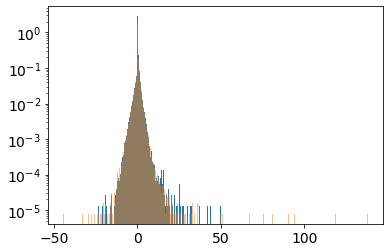

In [60]:
_=plt.hist(encoded_valid.flatten(),bins=1000,density=True, log=True)
_=plt.hist(encoded_train[:len(encoded_valid)].flatten(),bins=1000,density=True, alpha=0.5, log=True)

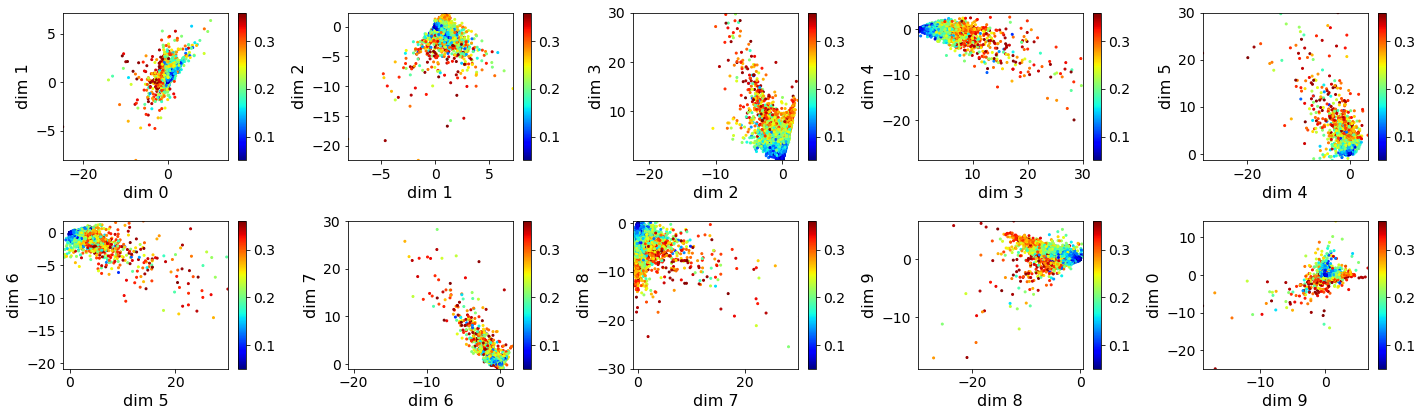

In [70]:
lims = 30

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,6))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=valid['z'], cmap='jet',s=4)
    ax[ii].set_xlim(max(min(encoded_valid[:,ii]),-lims),min(max(encoded_valid[:,ii]),lims))
    ax[ii].set_ylim(max(min(encoded_valid[:,jj]),-lims),min(max(encoded_valid[:,jj]),lims))
    ax[ii].set_xlabel('dim %d'%ii)
    ax[ii].set_ylabel('dim %d'%jj)
    plt.colorbar(im, ax=ax[ii])
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'encoded_valid_redshift_AE1_spec_norm.pdf'), bbox_inches='tight')
plt.show()


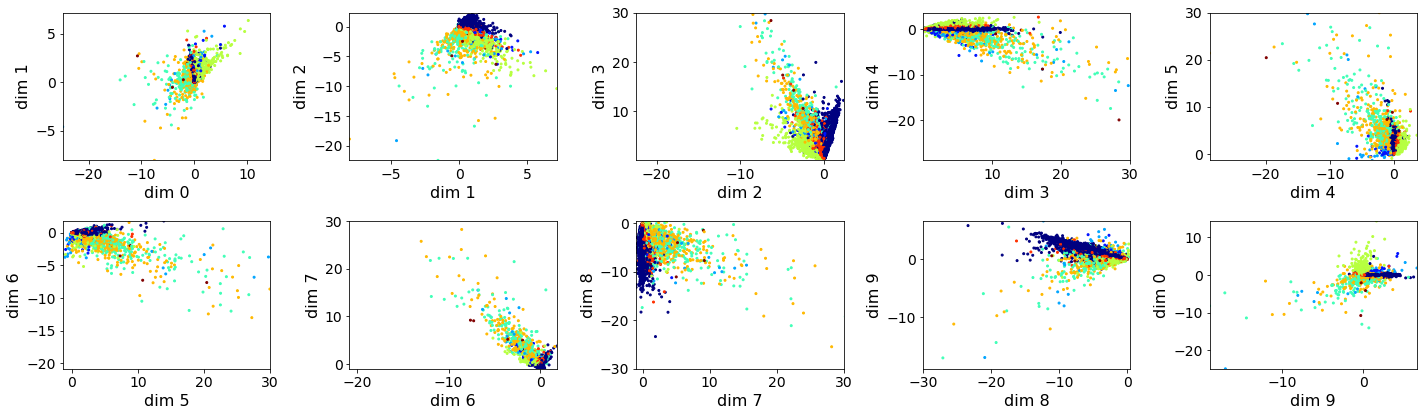

In [71]:
lims = 30

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,6))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=valid['subclass'], cmap='jet', s=4)
    ax[ii].set_xlim(max(min(encoded_valid[:,ii]),-lims),min(max(encoded_valid[:,ii]),lims))
    ax[ii].set_ylim(max(min(encoded_valid[:,jj]),-lims),min(max(encoded_valid[:,jj]),lims))
    ax[ii].set_xlabel('dim %d'%ii)
    ax[ii].set_ylabel('dim %d'%jj)
    #plt.colorbar(im, ax=ax[ii])
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'encoded_valid_subclass_AE1_spec_norm.pdf'), bbox_inches='tight')
plt.show()


In [62]:
import seaborn as sns

In [63]:
df1 = pd.DataFrame()
df1['subclass']=train['subclass']

In [64]:
import matplotlib

cmap = matplotlib.cm.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin=0, vmax=7)
rgba = cmap(norm(np.arange(8)))

In [65]:
new_label = np.asarray([40789,2098,214,205,3658,70,2225,183])
old_label = np.asarray([43168,423,105,563,3642,15,1486,40])

new_counts = new_label/old_label*(np.unique(df1['subclass'], return_counts=True)[1])

/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


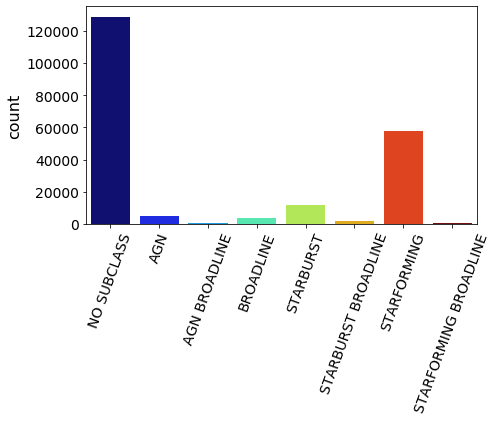

In [66]:
color_map = dict(zip(np.arange(8), rgba))
plt.figure(figsize=(7, 4))
p=sns.countplot(df1['subclass'],palette=color_map)
#p=sns.barplot(np.arange(8),new_counts,palette=color_map,alpha=1.0)
# plt.title('Total Athletes contribution in summer olympics over time')
labels =[]
for ii, x in enumerate(le.inverse_transform(np.arange(8))):
    if ii >0:
        labels.append(x.decode('utf-8'))
    else:
        labels.append('NO SUBCLASS') 
plt.xticks(np.arange(8), labels ,rotation=70)
plt.xlabel('')
# plt.ylabel('No. of Athlete')
plt.show()

In [67]:
noise            = np.ma.array(np.squeeze(valid['noise']),mask=~np.squeeze(valid['mask'].astype('bool')))
#noise_recon      = np.ma.array(np.tile(loss[0]/np.mean(valid['mask'],axis=0), (len(valid['noise']))).T,mask=~np.squeeze(valid['mask'].astype('bool')))
recon_error      = np.ma.mean(np.ma.array(np.squeeze(valid['spec'])-decoded_valid,mask=~np.squeeze(valid['mask'].astype('bool')))**2*(noise),axis=1)

/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Text(0, 0.5, '$\\chi^2$ distribution')

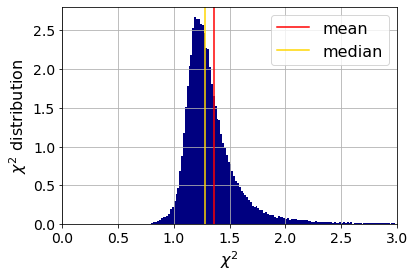

In [68]:
plt.hist(recon_error,bins=300,density=True,range=(0,5),color='navy')
plt.axvline(recon_error.mean(),color='red',label='mean')
plt.axvline(np.median(recon_error),color='gold',label='median')
plt.xlim(0,3)
plt.grid()
plt.legend()
plt.xlabel(r'$\chi^2$')
plt.ylabel(r'$\chi^2$ distribution')

Text(0.5, 0, '$\\chi^2$')

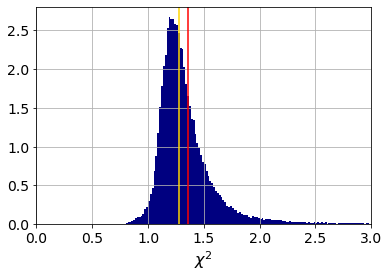

In [69]:
plt.hist(recon_error,bins=300,density=True,range=(0,5),color='navy')
plt.axvline(recon_error.mean(),color='red',label='mean')
plt.axvline(np.median(recon_error),color='gold',label='median')
plt.xlim(0,3)
plt.grid()
plt.xlabel(r'$\chi^2$')

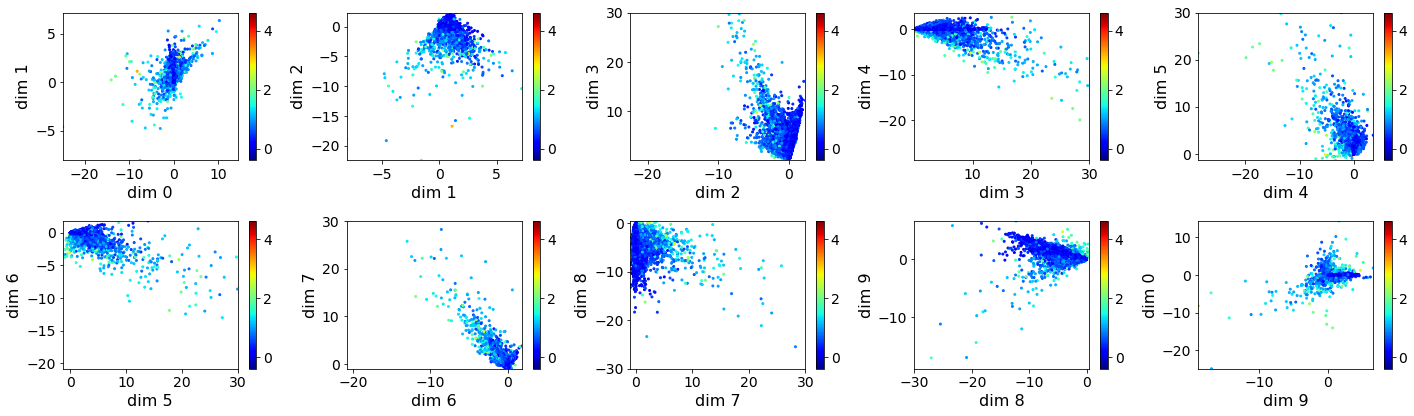

In [72]:
lims = 30

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,6))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=np.log(recon_error), cmap='jet', s=4)
    ax[ii].set_xlim(max(min(encoded_valid[:,ii]),-lims),min(max(encoded_valid[:,ii]),lims))
    ax[ii].set_ylim(max(min(encoded_valid[:,jj]),-lims),min(max(encoded_valid[:,jj]),lims))
    ax[ii].set_xlabel('dim %d'%ii)
    ax[ii].set_ylabel('dim %d'%jj)
    plt.colorbar(im, ax=ax[ii])
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'encoded_noise_AE1_spec_norm.pdf'), bbox_inches='tight')
plt.show()

In [73]:
wlmin, wlmax    = (3388,8318)
wl_range      = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl        = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

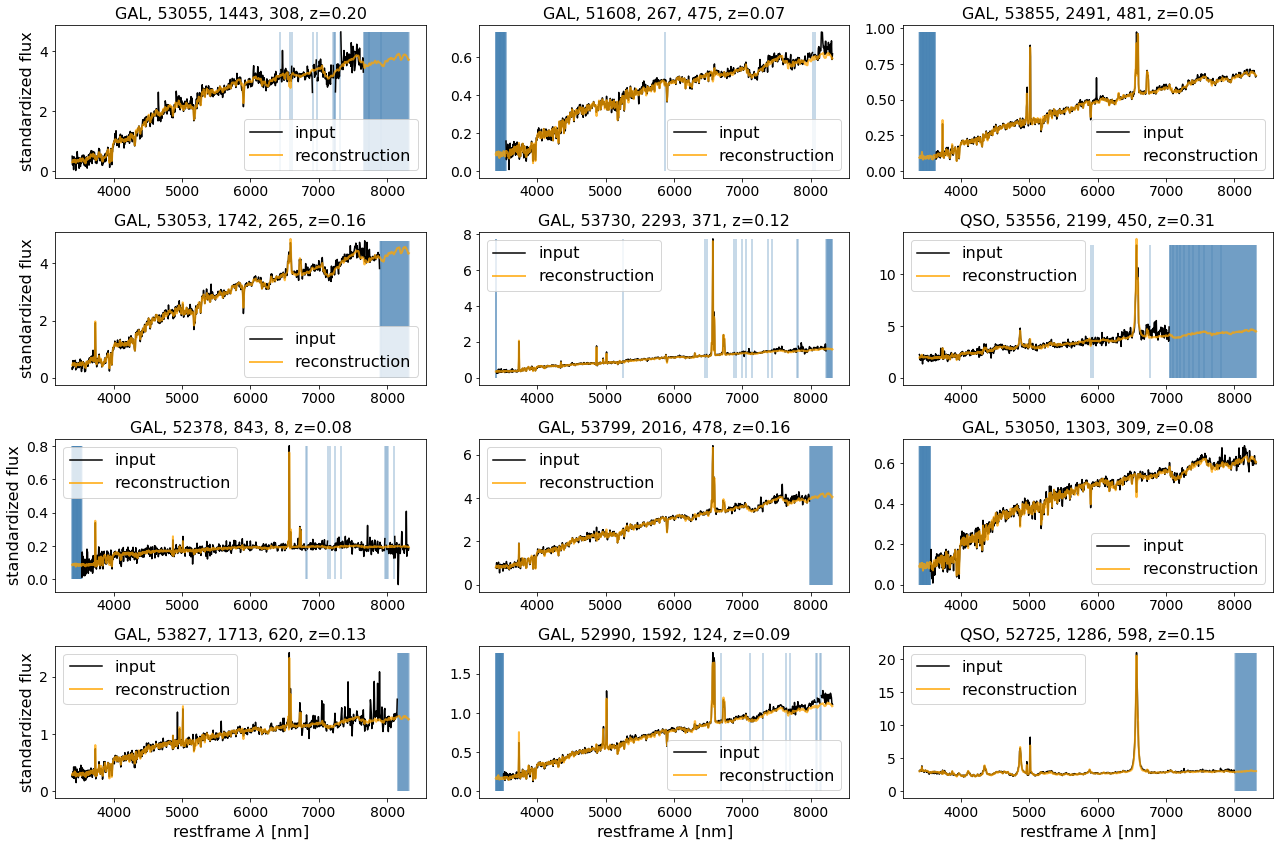

In [74]:
masked={}
masked['train'] = np.ma.array(np.squeeze(train['spec']),mask=~np.squeeze(train['mask'].astype('bool')))
masked['valid'] = np.ma.array(np.squeeze(valid['spec']),mask=~np.squeeze(valid['mask'].astype('bool')))
masked['test'] = np.ma.array(np.squeeze(test['spec']),mask=~np.squeeze(test['mask'].astype('bool')))
classes = {2:'GAL', 1:'QSO', 0:'STAR'}
fi, ax = plt.subplots(4,3,figsize=(18,12))
ax     = ax.flatten()
for ii in range(12):
    ind = (test['subclass']==(ii%8))
    ax[ii].set_title('%s, %d, %d, %d, z=%.2f'%(classes[test['class'][ind][ii]], test['MJD'][ind][ii],test['plate'][ind][ii],test['fiber'][ind][ii],test['z'][ind][ii]))
    ax[ii].plot(new_wl[1:],masked['test'][ind][ii],label='input', color='black')
    ax[ii].vlines(x=new_wl[1:][np.squeeze(~test['mask'][ind][ii].astype(bool))], ymin=0,ymax=max(test['spec'][ind][ii]), color='steelblue',alpha=0.4)
    ax[ii].plot(new_wl[1:],decoded_test[ind][ii], label='reconstruction',ls='-', color='orange', lw=2, alpha=0.75)

    ax[ii].legend()
    if ii in [9,10,11]:
        ax[ii].set_xlabel(r'restframe $\lambda$ [nm]')
    if ii%3==0:
        ax[ii].set_ylabel(r'standardized flux')       
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'reconstructions_test_AE1_spec_norm.pdf'), bbox_inches='tight')
plt.show()

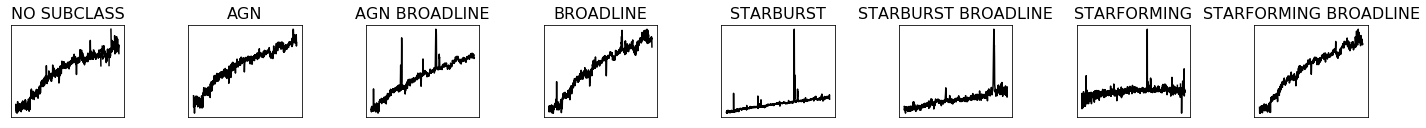

In [50]:
masked={}
masked['train'] = np.ma.array(np.squeeze(train['spec']),mask=~np.squeeze(train['mask'].astype('bool')))
masked['valid'] = np.ma.array(np.squeeze(valid['spec']),mask=~np.squeeze(valid['mask'].astype('bool')))
masked['test'] = np.ma.array(np.squeeze(test['spec']),mask=~np.squeeze(test['mask'].astype('bool')))
classes = {2:'GAL', 1:'QSO', 0:'STAR'}
fi, ax = plt.subplots(1,8,figsize=(20,2))
ax     = ax.flatten()
for ii in range(8):
    ind = (test['subclass']==(ii%7))
    ax[ii].set_title(labels[ii])
    ax[ii].plot(new_wl[1:],masked['test'][ind][ii],label='input', color='black')
    #ax[ii].vlines(x=new_wl[1:][np.squeeze(~test['mask'][ind][ii].astype(bool))], ymin=0,ymax=max(test['spec'][ind][ii]), color='steelblue',alpha=0.4)
    #ax[ii].plot(new_wl[1:],decoded_test[ind][ii], label='reconstruction',ls='-', color='orange', lw=2, alpha=0.75)

    #ax[ii].legend()
    # if ii in [9,10,11]:
    #     ax[ii].set_xlabel(r'restframe $\lambda$ [nm]')
    # if ii%3==0:
    #     ax[ii].set_ylabel(r'standardized flux')
    ax[ii].set_xticks([])
    ax[ii].set_yticks([])
plt.tight_layout()
#plt.savefig(os.path.join(plotpath,'reconstructions_test_AE1.pdf'), bbox_inches='tight')
plt.show()

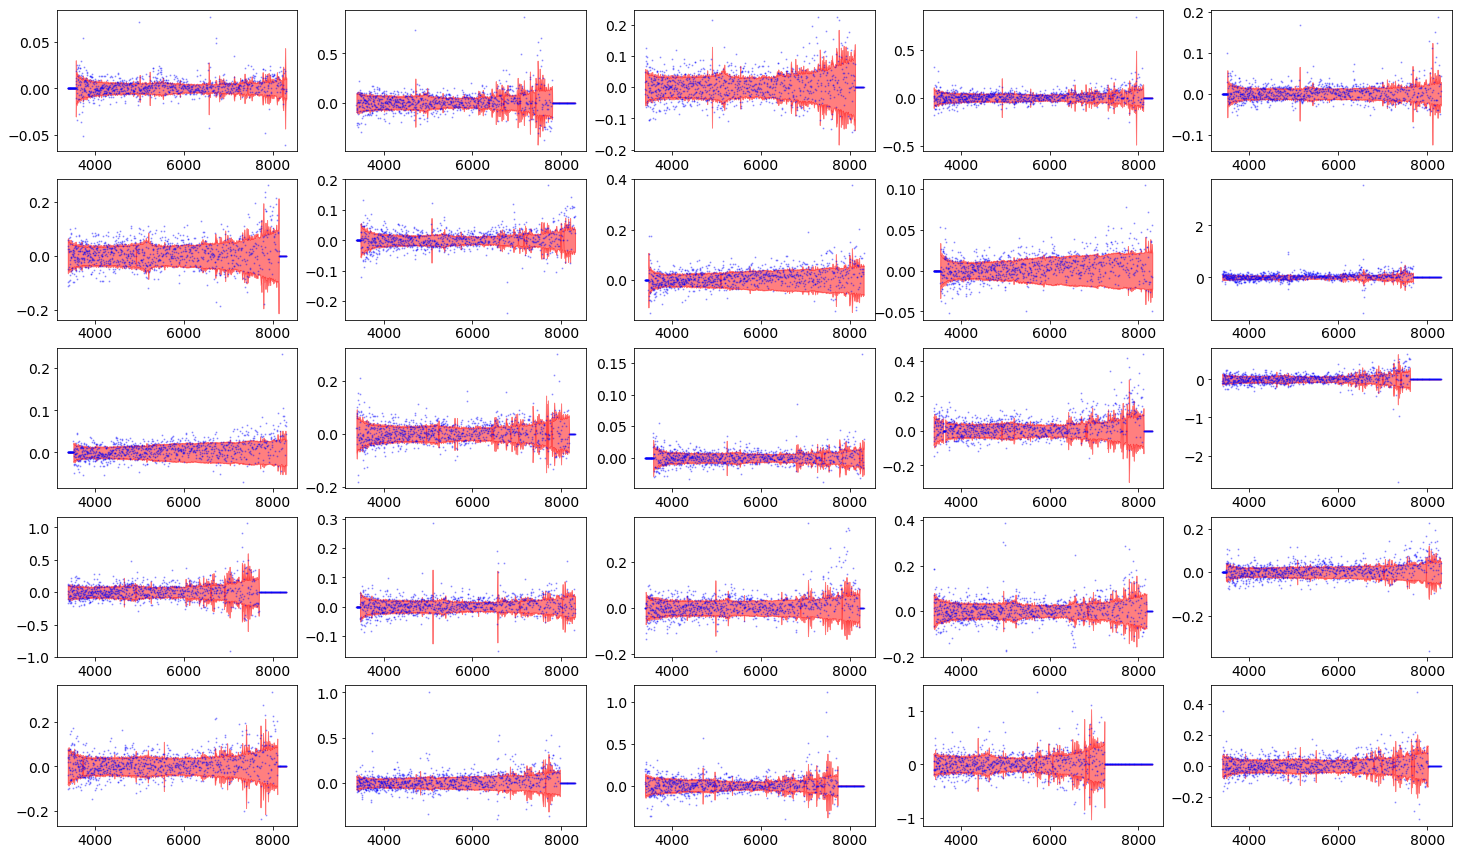

In [75]:
noise = np.zeros(valid['noise'].shape)
ind   = np.where(valid['noise']!=0)
noise[ind] = np.sqrt(1./np.squeeze(valid['noise'][ind]))

noise = np.squeeze(noise)


fig, ax = plt.subplots(5,5, figsize=(25,15))
ax = ax.flatten()
for nn, ii in enumerate(np.arange(25)):
    ax[nn].plot(new_wl[:-1], (np.squeeze(valid['spec'])[ii]-decoded_valid[ii])*np.squeeze(valid['mask'][ii]),color='blue', alpha=0.3,ls='',marker='o', markersize=1)
    ax[nn].fill_between(new_wl[:-1], -noise[ii], noise[ii], alpha=0.5, color='red')               
plt.show()

In [76]:
### Look at reconstruction ability as function of wavelength

In [77]:
def loss_by_wl(y_true, y_pred):
    loss           = (y_true[0]-y_pred)**2*y_true[2]*y_true[1]
    valid_loss     = np.mean(loss,axis=0)
    std_valid_loss = np.std(loss,axis=0)
    return valid_loss, std_valid_loss

In [78]:
loss = loss_by_wl((valid['spec'],valid['mask'],valid['noise']),np.expand_dims(decoded_valid,-1))

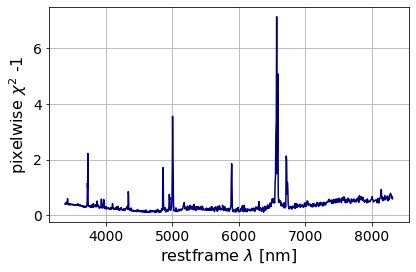

In [79]:
plt.plot(new_wl[:-1],loss[0]/np.mean(valid['mask'],axis=0)-1,color='navy')
plt.xlabel(r'restframe $\lambda$ [nm]')
plt.ylabel('pixelwise $\chi^2$ -1')
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'mean_reconstruction_error_AE1_spec_norm.pdf'), bbox_inches='tight')

In [80]:
Supernovas = pd.read_pickle('../forPub/Supernova_Sample.pkl')

In [81]:
seed=154
np.random.seed(seed)
sample = np.random.randint(0,len(test['spec']),12)

In [82]:
df1 = pd.DataFrame()
df1['MJD']   = test['MJD']
df1['plate'] = test['plate']
df1['fiber'] = test['fiber']
df1['index'] = np.arange(len(test['fiber']))
sns= df1.merge(Supernovas,how='inner',on=['plate','MJD','fiber'])

In [83]:
sns

,MJD,plate,fiber,index
0,51633,268,572,7249
1,52079,604,209,11580
2,51955,472,247,23135


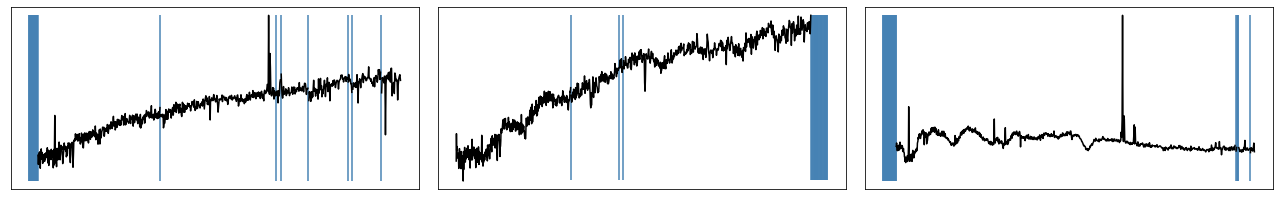

In [84]:
masked={}
masked['train'] = np.ma.array(np.squeeze(train['spec']),mask=~np.squeeze(train['mask'].astype('bool')))
masked['valid'] = np.ma.array(np.squeeze(valid['spec']),mask=~np.squeeze(valid['mask'].astype('bool')))
masked['test'] = np.ma.array(np.squeeze(test['spec']),mask=~np.squeeze(test['mask'].astype('bool')))
classes = {2:'GAL', 1:'QSO', 0:'STAR'}
fi, ax = plt.subplots(1,3,figsize=(18,3))
ax     = ax.flatten()
for ii in range(3):
    ind = sns['index']
    #ax[ii].set_title('%s, %d, %d, %d, z=%.2f'%(classes[test['class'][ind][ii]], test['MJD'][ind][ii],test['plate'][ind][ii],test['fiber'][ind][ii],test['z'][ind][ii]))
    ax[ii].plot(new_wl[1:],masked['test'][ind][ii],color='black')
    ax[ii].vlines(x=new_wl[1:][np.squeeze(~test['mask'][ind][ii].astype(bool))], ymin=0,ymax=max(test['spec'][ind][ii]), color='steelblue')
    #ax[ii].plot(new_wl[1:],decoded_test[ind][ii], label='reconstruction',ls='-', color='orange', lw=2, alpha=0.75)

    #ax[ii].legend()
    #if ii in [11,12]:
    #ax[ii].set_xlabel(r'restframe $\lambda$ [nm]')
    #if ii%2==0:
    #ax[ii].set_ylabel(r'standardized flux')
    ax[ii].set_xticks([])
    ax[ii].set_yticks([])
#plt.xticks([])
plt.tight_layout()
#plt.savefig(os.path.join(plotpath,'reconstructions_test_AE1.pdf'), bbox_inches='tight')
plt.show()

In [ ]:
51999, 362, 26

In [ ]:
np.where((valid['MJD']==51999)*(valid['plate']==26)*(valid['fiber']==362))

In [ ]:
import seaborn as sns

In [ ]:
penguins = sns.load_dataset("penguins")


In [ ]:
penguins.rename(columns={'bill_length_mm':'dim 1','bill_depth_mm':'dim 2'},inplace=True)

In [ ]:
penguins

In [5]:
data1 = penguins[(penguins['dim 1']>55.6)*(penguins['dim 2']<18)]
data2 = penguins[(penguins['dim 1']<35)*(penguins['dim 2']<16)]
data3 = penguins[(penguins['dim 1']<38)*(penguins['dim 2']>21)]
data4 = penguins[(penguins['dim 1']<50)*(penguins['dim 2']>21.2)]

/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, u

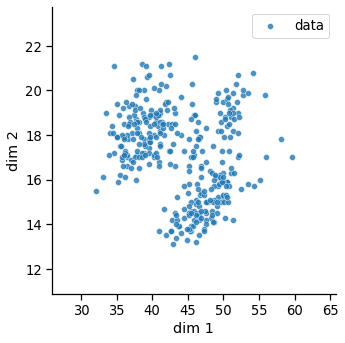

In [17]:

with sns.plotting_context('notebook',font_scale=1.2):
    sns.displot(penguins, x="dim 1", y="dim 2", kind="kde", alpha=0)
    sns.scatterplot(data=penguins, x="dim 1", y="dim 2", alpha=0.8 , label='data')
    # sns.displot(penguins, x="dim 1", y="dim 2", kind="kde", fontsize=12)
    # sns.scatterplot(data=data1, x="dim 1", y="dim 2")
    # sns.scatterplot(data=data2, x="dim 1", y="dim 2")
    # sns.scatterplot(data=data4, x="dim 1", y="dim 2")
    # sns.scatterplot(data=data3, x="dim 1", y="dim 2")

/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'fontsize'
  cset = contour_func(


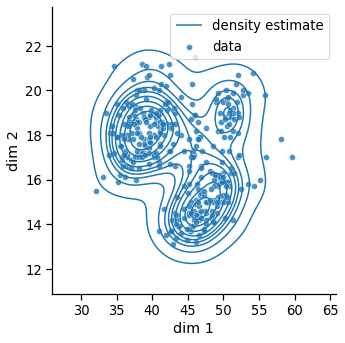

In [11]:
with sns.plotting_context('notebook',font_scale=1.2):
    sns.displot(penguins, x="dim 1", y="dim 2", kind="kde", fontsize=12, label='density estimate')
    sns.scatterplot(data=penguins, x="dim 1", y="dim 2", alpha=0.8 , label='data')
    # 
    # sns.scatterplot(data=data1, x="dim 1", y="dim 2", color='orangered', label='outlier')
    # sns.scatterplot(data=data2, x="dim 1", y="dim 2", color='orangered')
    # sns.scatterplot(data=data4, x="dim 1", y="dim 2", color='orangered')
    # sns.scatterplot(data=data3, x="dim 1", y="dim 2", color='orangered')

/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'fontsize'
  cset = contour_func(


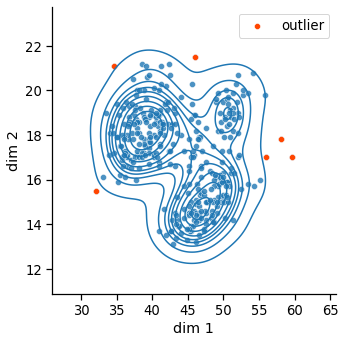

In [15]:
with sns.plotting_context('notebook',font_scale=1.2):
    sns.displot(penguins, x="dim 1", y="dim 2", kind="kde", fontsize=12)
    sns.scatterplot(data=penguins, x="dim 1", y="dim 2", alpha=0.8 ) 
    sns.scatterplot(data=data1, x="dim 1", y="dim 2", color='orangered', label='outlier')
    sns.scatterplot(data=data2, x="dim 1", y="dim 2", color='orangered')
    sns.scatterplot(data=data4, x="dim 1", y="dim 2", color='orangered')
    sns.scatterplot(data=data3, x="dim 1", y="dim 2", color='orangered')

In [14]:
import matplotlib.animation as animation